# Installation of required libraries

In [ ]:
!pip install qiskit

# Importing reqired libraries

In [34]:
from qiskit import *
from qiskit.visualization import plot_bloch_multivector
import numpy as np
from scipy.optimize import minimize , fmin_cobyla

# The Start -  A simple 1 qubit variational circuit.

### To reach any point in spherical coordinate we need three paramters : Radius $R$ , $\theta$ , $\phi$ . But in Bloch sphere, the radius is always 1 so it is sufficient to reach any point on the bloch sphere with just two parameters $\theta$ and $\phi$. This is denoted in the picture below.

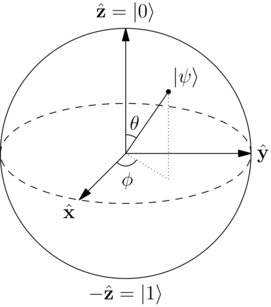

# Creating One qubit universal paramaterized circuit.

### Here $\theta$ is the angle made by the vector and z axis and it is affected by rotating the vector along Y-axis. $\phi$ is angle made by the projection of vector on X-Y plane and the X-axis. It is affected by rotating the vector along Z-axis. 

In [246]:
def q1_var_circuit(theta,phi):
  qc = QuantumCircuit(1,1)
  qc.ry(theta,0)
  qc.rz(phi,0)
  result = execute(qc,backend = Aer.get_backend('statevector_simulator')).result() # Do the simulation, returning the result
  out_state = result.get_statevector()
  return(out_state)

### To show that the parametrized circuit reproduces any point on bloch sphere it is sufficent to show that circuit can reproduce basis state $|0\rangle$   $|1\rangle$ and  $|+\rangle$   $|-\rangle$ as any point on bloch sphere can be represented as linear combination of these basis states.

## Reproducing  $|0\rangle$   $|1\rangle$

#### $|0\rangle$ - State

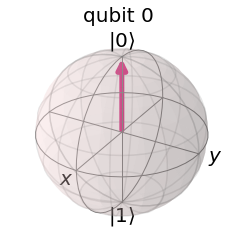

In [247]:
theta = 0
phi = 0
plot_bloch_multivector(q1_var_circuit(theta,phi))

#### $|1\rangle$ - State

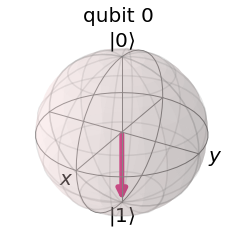

In [248]:
theta = np.pi
phi = 0
plot_bloch_multivector(q1_var_circuit(theta,phi))

#### $|+\rangle$ - State

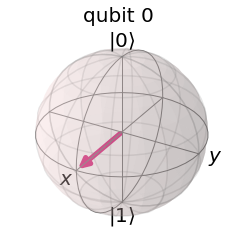

In [252]:
theta = np.pi/2  
phi = 0
plot_bloch_multivector(q1_var_circuit(theta,phi))

#### $|-\rangle$ - State

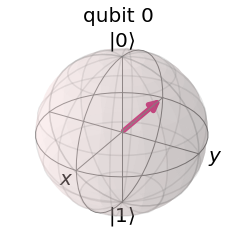

In [255]:
theta = -np.pi/2  
phi = 0
plot_bloch_multivector(q1_var_circuit(theta,phi))

#### Thus the variational circuit can reproduce any state as it is able to produce the basis states with parameters $\theta$ and $\phi$

# Swap test 

To contruct swap test to compare two state $|\psi\rangle$ and $|\phi\rangle$ where $|\psi\rangle$ and $|\phi\rangle$ are one qubit state we need three qubits to form a quantum circuit as shown below. 



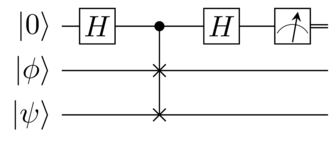

For our case the random state is $|\phi\rangle$ and state of variational circuit is $|\psi\rangle$. 

The measurement of the first qubit will give out an probability for $|0\rangle$  = 0.5 + 0.5 $ \langle \psi|\phi\rangle $. If the states are orthogonal we get 0.5 as the probability of $|0\rangle$ while if the states are same we get 1 as the prabability for $|0\rangle$.

We need to estimate the parameters which makes $|\phi\rangle$ = $|\psi\rangle$. Thus we modify the cost function as  
CF = 1 - probability of $|0\rangle$. Thus the cost fucntion will take the minimum value if $|\phi\rangle$ = $|\psi\rangle$.

In [256]:
def swap_test_circuit(random_state , theta , phi):
  qc = QuantumCircuit(3,1)
  qc.initialize(random_state , 1)     #initializing the random state
  qc.ry(theta,2)                      #paramaterized rx rotation 
  qc.rz(phi,2)                        #paramaterized rz rotation
  '''SWAP TEST'''
  qc.h(0)                             
  qc.append(circuit.library.CSwapGate(),[0,1,2])
  qc.h(0)
  qc.measure(0,0)
  return(qc)

In [257]:
def cost_function(params,random_vec = random_vec):
  theta = params[0] 
  phi = params[1]
  qc = swap_test_circuit(random_vec , theta , phi)
  result = execute(qc,backend = Aer.get_backend('qasm_simulator'), shots = 10**5).result() # Do the simulation, returning the result
  out_state = result.get_counts()
  exp = 1 - (out_state['0']/10**5) # Calculating probability of state 0 and evaluating the cost function
  print(" Cost funtion value : ", exp)
  return exp

In [262]:
random_vec = np.random.rand(2)
random_vec = random_vec/np.linalg.norm(random_vec)
opt = minimize(cost_function,[3,3],method = 'Powell', options={'maxiter' : 500  })

 Cost funtion value :  0.4675
 Cost funtion value :  0.46594
 Cost funtion value :  0.26914000000000005
 Cost funtion value :  0.0010000000000000009
 Cost funtion value :  0.0032200000000000006
 Cost funtion value :  0.0009099999999999664
 Cost funtion value :  0.42030999999999996
 Cost funtion value :  0.09138999999999997
 Cost funtion value :  0.033399999999999985
 Cost funtion value :  0.0008299999999999974
 Cost funtion value :  0.0011200000000000099
 Cost funtion value :  0.0008399999999999519
 Cost funtion value :  0.031120000000000037
 Cost funtion value :  0.10760999999999998
 Cost funtion value :  0.0008500000000000174
 Cost funtion value :  0.02471000000000001
 Cost funtion value :  0.0024999999999999467
 Cost funtion value :  9.99999999995449e-06
 Cost funtion value :  0.0
 Cost funtion value :  5.999999999994898e-05
 Cost funtion value :  2.0000000000020002e-05
 Cost funtion value :  0.0
 Cost funtion value :  9.99999999995449e-06
 Cost funtion value :  9.99999999995449e-06

### Random state

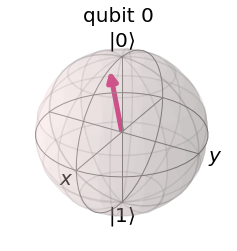

In [266]:
qc = QuantumCircuit(1)
qc.initialize(random_vec,0)
result = execute(qc,backend = Aer.get_backend('statevector_simulator')).result() # Do the simulation, returning the result
out_state = result.get_statevector()
plot_bloch_multivector(out_state)

### State from variational circuit using found parameters

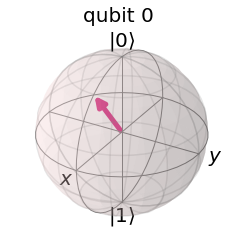

In [267]:
var_state = q1_var_circuit(opt['x'][0] , opt['x'][1])
plot_bloch_multivector(var_state )

### Accuracy of the found state

Accuracy can be show by computing the dot product between the random state and the state of variational circuit. The more the dot product nearer to one, the better the approximation.

In [268]:
print("The accuracy of the state is : ", abs(np.dot(random_vec,var_state)))

The accuracy of the state is :  0.9818802140512514


This accuracy says how well the state is estimated by parametrizing the circuit. The accuracy depends on the optimiser and number of shots. Here we used non-gradient optimiser. But there are Stochastic optimisers like Simultaneous Perturbation Stochastic Approximation (SPSA) which will give even better results.

# N Qubit State

For the purpose reducing complexity in classical simulation of quantum circuit, Number of qubits for random state is restricted to 15.

In [375]:
n = 3 #Lets take 3 qubit random state and maximum we can go upto 15 qubit for classical simulation in qiskit
random_state = [0 for i in range(2**n)]
random_state[np.random.randint(0,2**n)] = 1
print('The random state : ',random_state)

The random state :  [0, 1, 0, 0, 0, 0, 0, 0]


For this setting we take just three paramters to find the circuit because being a product state, it is sufficient to find which qubits are in state $|1\rangle$. Thus an rx gate with parameter $ p_{i} \pi$ is given for ith qubit where our optimiser check if $p_{i}$ is either 0 or 1 impliying the particular qubit being either in $|0\rangle$ or $|1\rangle$ respectively 

In [381]:
def N_var_qubit_state(params , random_state, n):
  a = QuantumRegister(1,'ancilla')
  r = QuantumRegister(n, 'random state circuit')
  v = QuantumRegister(n, 'variational circuit')
  c = ClassicalRegister(1)
  qc = QuantumCircuit(a,r,v,c)
  qc.initialize(random_state,r) #initializing random state
  #variational part
  for i in range(n):
    qc.rx(np.pi*params[i],v[i])
  '''SWAP TEST'''
  qc.h(0)
  for i in range(n):
    qc.append(circuit.library.CSwapGate(),[0,r[i],v[i]])
  qc.h(0)
  qc.measure(0,0)
  return(qc)

In [382]:
def n_cost_fn(params,random_state=random_state,n=n):
  qc = N_var_qubit_state(params,random_state,n) #getting the quantum circuit
  result = execute(qc,backend = Aer.get_backend('qasm_simulator'), shots = 1024).result() # Do the simulation, returning the result
  out_state = result.get_counts()
  exp = 1 - (out_state['0']/1024) #cost function
  return exp

In [383]:
#Grid search for the paramters
for j in range(2**n):
  params = [0 for i in range(n)] #initialising all the parameters in zero
 #converting j to binary since our parameter will be a binary number from 0 to 2**n
  b = bin(j)[2:]
  b = b[::-1]
  for i in range(len(b)) :
    params[n-i-1] = int(b[i])
  #evaluating cost_function
  cost = n_cost_fn(params,random_state=random_state , n = n)
  if cost == 0 :
    x = params
    break
print('The required parameter is',x)

The required parameter is [1, 0, 0]


# Random State

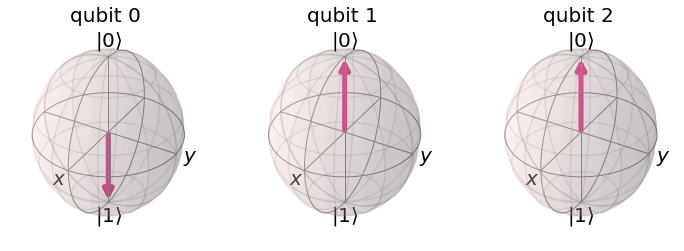

In [384]:
qc = QuantumCircuit(n)
qc.initialize(random_state,[i for i in range(n)])
result = execute(qc,backend = Aer.get_backend('statevector_simulator')).result() # Do the simulation, returning the result
out_state = result.get_statevector()
plot_bloch_multivector(out_state)

# State with calculated parameter

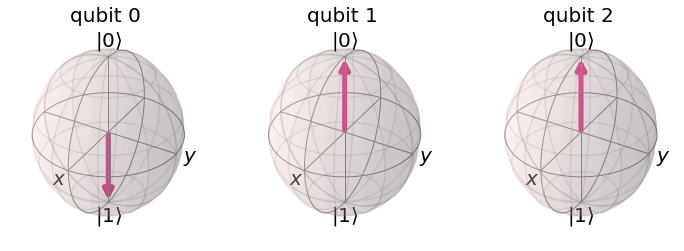

In [385]:
qc = QuantumCircuit(n)
for i in range(n):
  qc.rx(np.pi*params[i],i)
result = execute(qc,backend = Aer.get_backend('statevector_simulator')).result() # Do the simulation, returning the result
out_state = result.get_statevector()
plot_bloch_multivector(out_state)

Thus the qubit - states are reconstructred using SWAP test. This can be used for any qubits. But at present only 32 qubits be simulated in qasm simulator there is a upper limit for the number of qubits used to denote random_state (i.e) 15 qubits.